# SLT-CE-5: Constant Shift Embedding

# Introduction

## Task

Many real-world phenomena are described by pairwise proximity data, modeling interactions between the entities of the system. This in contrast to the more common situation where each data sample is given as a feature vector. Even though the clustering of the proximity data may be performed directly on the data matrix, there are some advantatages of  embedding the data into a vector space. For example, it enables the use of some standard preprocessing techniques such as denoising or dimensionality reduction. In this coding exercise, we will explore the tecnhique called _Constant Shift Embedding_ for restating pairwise clustering problems in vector spaces [1] while preserving the cluster structure. We will apply the algorithm described in [1] to cluster the groups of research community members based on the email correspondence matrix. The data and its description is given in [2].

### References 

[1] [Optimal cluster preserving embedding of nonmetric proximity data](https://ieeexplore.ieee.org/document/1251147)

[2] [email-Eu-core](https://snap.stanford.edu/data/email-Eu-core.html)

## Setup

We start by importing some possibly necessary python packages.

In [1]:
import numpy as np
import sklearn as skl
import matplotlib.pylab as plt
import pylab
from mpl_toolkits.mplot3d import Axes3D
import jgraph as ig
from sklearn.cluster import KMeans
import scipy
import scipy.linalg

# Fix randoom seed for reproducibility
np.random.seed(42)

The number of nodes is hardcoded for simplicity (taken from [2]):

In [2]:
NUM_NODES = 1005

We load the file which contains the list of interactions between the community members (nodes). Our data matrix represents an undirected graph which connects two nodes if there was at least one email sent between the two corresponding community members. Thus our data matrix is essentially an adjacency matrix.

In [67]:
# initialize data matrix which willadjacency matrix
DATA = np.zeros((NUM_NODES, NUM_NODES)) + np.eye(NUM_NODES)
LABEL = np.zeros((NUM_NODES,))

# fill out the symmetric adjacency matrix
with open("email-Eu-core.txt") as file:
    for line in file:
        pair = [int(x) for x in line.split()]
        DATA[pair[0],pair[1]] = 1
        DATA[pair[1],pair[0]] = 1
        
with open('email-Eu-core-department-labels.txt') as file:
    for line in file:
        pair = [int(x) for x in line.split()]
        LABEL[pair[0]] = pair[1]

        
LABEL_SORT_INDEX = np.argsort(LABEL)
print(LABEL_SORT_INDEX)

[122 402 214 ... 186 758 941]


Next we define a class which contains main functionalities - TO BE IMPLEMENTED.

In [142]:
class ConstantShiftEmbedding(skl.base.BaseEstimator, skl.base.TransformerMixin):
    """Template class for Constant Shift Embedding (CSE)
    
    Attributes:
        PMAT (np.ndarray): Proximity matrix used for calculating the embeddings.
        S (np.ndarray): Similarity matrix.
        D (np.ndarray): Dissimilarity matrix.
        
    """
    
    def __init__(self):
        self.PMAT = None
        self.S = None
        self.D = None
        # Add/change parameters, if necessary.
        self.D_orig = None
        
    def get_similarity_matrix(self, PMAT):
        """
        +1/n if neighbors
        +1/n if neighbor has same neighbor
        """
        n, n = PMAT.shape
        NN = np.eye(n)
        z = 1/n
        for i in range(int(np.ceil(np.sqrt(n)))):
            for j in range(n):
                if i == j:
                    NN[i,i] = 1 # absolutly equal
                    continue
                elif PMAT[i,j] == 1: # i,j are neighbors
                    NN[i,j] += z # +z because of neighbors
                # NN[j,i] += z #
                # get neighbors of each
                n_i = PMAT[i,:]
                n_j = PMAT[j,:]
                # count same neighbors
                eq = np.sum((n_i + n_j)  == 2)
                NN[i,j] += eq*z
                #NN[j,i] += eq*z
        return np.maximum(NN, NN.transpose())
    
    def get_disimilarity_matrix(self, PMAT):
        n, n = PMAT.shape
        D = np.ones(PMAT.shape)
        
        for i in range(n):
            for j in range(n):
                if i == j:
                    D[i,i] = 0 
                elif PMAT[i,j] == 1:
                    D[i,j] -= 0.5
        return D
    
    def fit(self, PMAT):
        """ Calculate similarity/dissimiliarity matrix and all
        the necessary variables for calculating the embeddings.

        Args:
            PMAT (np.ndarray): proximity matrix
        """

        # Save data
        self.PMAT = PMAT
        m, n = self.PMAT.shape
        self.S = PMAT #self.get_similarity_matrix(PMAT)
        self.D = np.empty(self.S.shape)

        for i in range(m):
            for j in range(n):
                self.D[i, j] = self.S[i, i] + self.S[j, j] - 2 * self.S[i, j]
        self.D_orig = self.D.copy()
        
        e_n = np.ones(n).reshape(n, 1)
        self.Q = np.eye(n) - e_n * e_n.T / n
        Sc = -1 / 2 * np.dot(np.dot(self.Q, self.D), self.Q)
        
        assert (np.allclose(np.sum(Sc, axis=0), np.zeros(n)))
        assert (np.allclose(np.sum(Sc, axis=1), np.zeros(n)))
        
        w = scipy.linalg.eigh(Sc, eigvals_only=True)
        lambda_n = np.min(w)
        self.S = Sc - lambda_n * np.eye(n)

        ## IMPLEMENT THIS METHOD

    def get_embedded_vectors(self, p):
        """Return embeddings

        Args:
            p (np.ndarray): cut-off value in eigenspectrum

        Returns:
            Xp (np.ndarray): embedded vectors

        """


        # Sc = VEV'
        eigenval, eigenvec = scipy.linalg.eigh(self.S)
        
        indx = np.argsort(-eigenval)
        eigenval, eigenvec = eigenval[indx], eigenvec[indx]

        indx = eigenval > p
        eigenval, eigenvec = eigenval[indx], eigenvec[indx]

        Xp = np.dot(eigenvec.T, np.sqrt(np.diag(eigenval)))
        self.eigv = eigenval
        return Xp

# Problems:

Solve all the problems to get 1 point. To get an additional point you need to solve the extension. 

_Note that the extension in this coding exercise will not be an independent task, but rather a valid proof that your results are aligned with the ground truth provided in [2]. Hence you will get an additional point if you can show that not only you are able to implement and visualize CSE algorithm, but also that you can actually make it work on a real-life data set._  

Note that above all, we will validate the working code. Make sure that your plots are readable and informative.

## Problem 0

Describe briefly and consicely the model given in [1]. Explain the main steps of _Constant Shift Embedding_ algorithm.

*Brief description of the model/algorithm:*
There have been a lot of machine learning algorithms developed that work on data that is represented as a vector. But nature is seldom described vectorally. There are a lot of structures like protein and social networks graphs that can't be described easily in a vector. The CSE algorithm gives us a tool that transforms structures that we can describe by similarity/dissimilarity into a vector by fully preserving the inherit structure. <br>

Algorithm:  <br>
1) Decomposition of similiarity matrix into dissimilarity matrix: $D_{ij} = S_{ii} - S_{ij}$  <br>
2) Centralization: $S^c = -\dfrac{1}{2}QDQ$ <br>
3) Diagonal shift to make matrix p.s.d: $\tilde{S} = S^c - \lambda_n(S^c)I_n$ where lambda n is the smallest eigenvalue. <br>
4) Make the eigenvalue decomposition to get the embeddings since now: $\hat{S} = XX^T$<br> which gives us finally the wanted vector embeddings. 


## Problem 1

Implement Constant Shift Embedding. We start off by making an instance of the corresponding class.

In [143]:
CSE = ConstantShiftEmbedding()

In [144]:
t = CSE.get_similarity_matrix(DATA)
n,n = t.shape
print(np.all(t == t.T))

True


Fit the data matrix. _fit(...)_ method computes necessary variables which can be later on used to produce embeddings [1].

In [145]:
CSE.fit(DATA)

## Problem 2

Next, try to find approximately optimal $p = p^∗$, a cut-off value which removes noise from the data. To do that, produce an eigen-spectrum plot as shown in [1] figure 4a and briefly explain your choice of $p^∗$.

In [146]:
Xp = CSE.get_embedded_vectors(0)

## Determine a good cut-off value
p_opt = 23.0 ## change accordingly
print("Chosen cut-off value is: ",p_opt)

Chosen cut-off value is:  23.0


I chose a threshold as in plot 4a as soon it gets somewhat linearly decreasing.

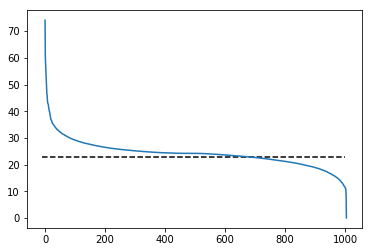

In [147]:


## Plot spectrum and indicate the cut-off value on the spectrum
fig= plt.figure()
plt.plot(np.arange(0, len(CSE.eigv)), CSE.eigv)
plt.hlines(p_opt,xmin=-10, xmax=1000, linestyles='dashed')
plt.show()

## Problem 3

Perform K-MEANS algorithm on the embedded vectors derrived from CSE. You may use the sklearn implementation of K-MEANS. Plot the distance matrices for varying number of clusters K, both for the denoised ($p = p^*$ - from the previous step) and the original version as shown in figure 5 in [1]. To make the plots meaningful, sort the nodes according to the cluster belongings (see the figure). For now, there is no need to include the actual ground truth labels given in [2].

In [148]:
Xp_opt = CSE.get_embedded_vectors(p_opt)
## Distance matrices
km = KMeans(n_clusters=42)
km.fit(Xp_opt)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=42, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

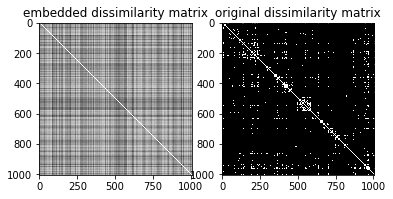

In [149]:
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import normalize

d_embedded = pdist(Xp_opt, metric='sqeuclidean')
d_embedded = squareform(d_embedded)[LABEL_SORT_INDEX, :][:, LABEL_SORT_INDEX]

d_orig = CSE.D_orig[LABEL_SORT_INDEX, :][:, LABEL_SORT_INDEX]


fig, ax = plt.subplots(ncols=2)
ax[0].imshow(d_embedded, cmap='Greys')
ax[0].set_title('embedded dissimilarity matrix')
ax[1].imshow(d_orig,  cmap='Greys')
ax[1].set_title('original dissimilarity matrix')
plt.show()


## Problem 4

Now calculate the embeddings for p = 2, 3 and plot clusterings for a few values of K. Producing 2D and 3D embeddings allows us to nicely visualize generated clusters. Alternatively, you could use $p^*$ and then apply a dimensionality reduction technique to move to 2,3-dimensional space. You could use PCA, LLE, t-SNE etc. figure out what works for you. As an example see figure 6 (b) from [1] where CSE is combined with PCA.

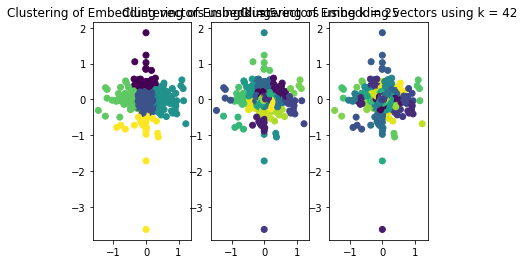

In [150]:


Xp_2 = Xp_opt[:, :2]

clusters = [5,25,42]
fig, ax = plt.subplots(1,3)
for i,k in enumerate(clusters):
    km = KMeans(n_clusters=k).fit(Xp_2)
    y_pred = km.predict(Xp_2)
    ax[i].scatter(Xp_2[:,0], Xp_2[:,1], c=y_pred)
    ax[i].set_title('Clustering of Embedding vectors using k = {}'.format(k))
    


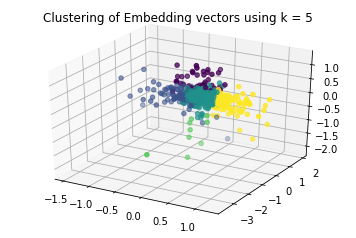

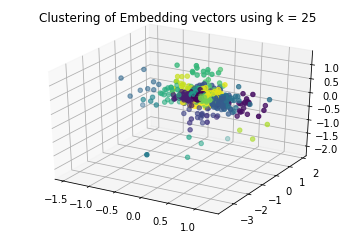

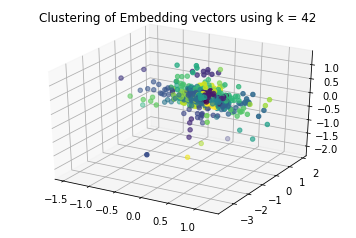

In [151]:

Xp_2 = Xp_opt[:, :3]

clusters = [5,25,42]

for i,k in enumerate(clusters):
    km = KMeans(n_clusters=k).fit(Xp_2)
    y_pred = km.predict(Xp_2)
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(Xp_2[:,0], Xp_2[:,1], Xp_2[:,2], c=y_pred)
    ax.set_title('Clustering of Embedding vectors using k = {}'.format(k))
    


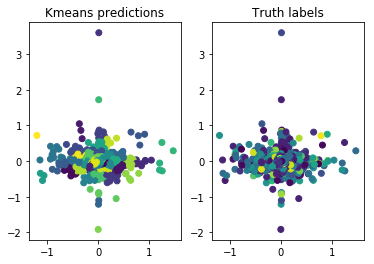

In [153]:
from sklearn.decomposition import PCA

Xp = CSE.get_embedded_vectors(20)

# denoisening
Xp_denoise = PCA(n_components=2).fit_transform(Xp)

## Distance matrices
km = KMeans(n_clusters=42)
km.fit(Xp_denoise)


fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].scatter(Xp_denoise[:, 0], Xp_denoise[:, 1], c=km.labels_)
ax[0].set_title('Kmeans predictions')

ax[1].scatter(Xp_denoise[:, 0], Xp_denoise[:, 1], c=LABEL)
ax[1].set_title('Truth labels')
plt.show()


## Problem 5 [optional]

Try the graph plot tools provided by python library [igraph](http://igraph.org/python/) to visualize the network and clusters.

*Hint:* Python igraph is a very nice and efficient graph library (see references). We recommend to check it
out. Especially, you can also plot networks with it and color the clusters.

In [17]:
## Your igraph visualization

## Remarks on the computational issues

_Insert here:_

## Extension

Finally, to evaluate the quality of the above derived clusters, let's compare our predictions with the ground truth. We will use the actual member-institution mappings given in [2].

To that end, solve at least one of the two following tasks to get an extra point:

1. Find a principled way to discover the true number of clusters, and show that your systematic search can recover the true number of clusters (which is 42 according to [2]) . You may consider using some stability measures mentioned and referenced in [1] or you may browse the literature to find something you like more to perform the model selection. As an example see figure 4 (b) in [1].
2. Visually or quantitatively, in a clever and convincing way, show that the K-MEANS generated clusters overlap with the ground truth clusters (member affiliations). How can we measure the overlapping of the predicted and true clusters?

In [18]:
# Initialize community members affeliation array
AFFILIATIONS = np.zeros((NUM_NODES, ))

# Fill out the affiliation array
with open("email-Eu-core-department-labels.txt") as file:
    for line in file:
        pair = [int(x) for x in line.split()]
        AFFILIATIONS[pair[0]] = pair[1]

# Number of organizations is 
print("The true number of clusters (departments) is: ",len(np.unique(AFFILIATIONS)))

The true number of clusters (departments) is:  42


In [19]:
# Here you can provide plots and calculations

# Extra Comments?

If there is anything that you liked or disliked in this exercise, please let us now by noting that down in this box. This will help us improve our exercises. Thank you in advance!